In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
%matplotlib inline
from game import game, random_connection_game

In [2]:
import time
from IPython.display import clear_output

In [3]:
Hint = np.random.randn(9,9)
Hint = 0.1*(Hint +Hint.transpose())


In [4]:
Hint.max()

0.311357659790974

In [5]:
Memb = 25
newg = game(Hint, Memb = Memb)

In [6]:
newg.state.shape

(2, 25, 25)

In [7]:
def randomAgent(state, Memb = 25):
    move = random.randint(3)
    spin_1 = random.randint(Memb)
    spin_2 = random.randint(4)
    return (move, spin_1, spin_2)

In [8]:
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

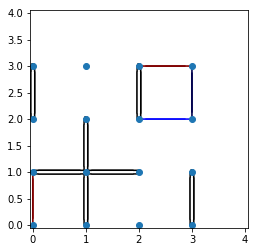

-8.25 16 (0, 13, 2) 46


In [9]:
# Reset!
Memb = 16

env = random_connection_game(9,  Memb, 
                             max_consecutive_failures = 50)

state = env.reset()
fig, ax = env.plot()
score = 0.0
actions = []
for j in range(2000):
    clear_output(wait=True)

    action = randomAgent(state, Memb)
    state, reward, done =env.step(action)
    score += reward
    actions.append((*action, reward))

    fig, ax = env.plot()
    plt.show()
    print(score, env.N, action, env.terms_left)
    if done >0:
        break